# Actor Critic Method (AC, A3C)

###   (value-based) Q learning : Critic
###  (action-based) Policy Gradient  = Actor 

This notebook defines Critic and Actor class, and train AC on game LunarLanderV2.0.




In [1]:
import gym
from gym import envs
from gym import wrappers

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import argparse
import logging
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from Network.CNN import CNN
from Network.deepnetsoftmax import Netsoftmax
from Network.deepnet import Net



# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [2]:
configC = {
    "inputs_dim": 8,
    "hidden_dim": 50,
    "outputs_dim": 1,     # one state value of given state
    "GAMMA": 0.99,
    "learning_rate": 0.00025,
    "weight_decay": 0.0001,
    "betas": (0.001, 0.9)
    
    
}

configA = {
    "inputs_dim": 8,
    "hidden_dim": 50,
    "outputs_dim": 4,    # action space probability
    "GAMMA": 0.99,
    "learning_rate": 0.00025,
    "weight_decay": 0.0001,
    "betas": (0.001, 0.9)
    
}

In [3]:
class Critic(object):
    """Same as Q learning. 
       Estimate state value, not state action value. 
       Compute the loss between v and v_next
    
       TD_error = (r+gamma*V_next) - V_eval
    
        In AC, Critic leave the job of picking action to Actor.
        Only make comments, i.e. compute vt in -log(prob)*vt.
    """
    
    def __init__(self, observation_space, action_space, lr_scheduler=None): 
    # 搭建好 Critic 神经网络
        self.q = Net(observation_space.shape[0], \
                        configC["outputs_dim"], configC["hidden_dim"])
        
        self.optimizer = optim.Adam(self.q.parameters(), lr=configC["learning_rate"], \
                                        betas=configC["betas"], \
                                        weight_decay=configC["weight_decay"])
        self.loss =  torch.nn.MSELoss()  
        self._v_=[]
        
        
    def learn(self, s, r, s_):  
    # Critic 的更新很简单, 就是像 Q learning 那样更新现实和估计的误差 (TD error) 
    # 学习 状态的价值 (state value), 不是行为的价值 (action value),
    # 计算 TD_error = (r + v_) - v,
    # 用 TD_error 评判这一步的行为有没有带来比平时更好的结果,
    # 可以把它看做 Advantage    
        s = Variable(torch.from_numpy(np.asarray(s))).float().view(1, configC["inputs_dim"])     
        s_ = Variable(torch.from_numpy(np.asarray(s_)), volatile=True).float().view(1, configC["inputs_dim"])  
        
        self.optimizer.zero_grad()
    
        state_values = self.q(s)    # v
    
        next_state_values = self.q(s_)   # v_
        next_state_values.volatile = False
        
        expected_state_values = torch.add((next_state_values * configC["GAMMA"]), r)  # r+gamma*v_
        
        loss = self.loss(state_values, expected_state_values)   # Mean square loss TD_error = (r+gamma*V_next) - V_eval
     
        loss.backward()
        self.optimizer.step()
    
        loss = float(loss.data.numpy()[0])
        self._v_.append(float(state_values.data.numpy()[0]))
        return loss
        
        
    def plot():
        return
           

In [4]:
 class Actor(object):
    """Policy Gradient Learning algorithm.
    
       Action based method: network estimate the probability of each action P(a),
       loss is log probability * td_error, 
       P(a) reinforced by rewards from RL environment.
       
       update over every epoch (v.s.per step)
    """
    
    
    def __init__(self, observation_space, action_space, lr_scheduler=None):
        self.q = Netsoftmax(observation_space.shape[0], \
                        configA["outputs_dim"], configA["hidden_dim"])
       
        self.optimizer = optim.Adam(self.q.parameters(), lr=configA["learning_rate"], \
                                        betas=configA["betas"], \
                                        weight_decay=configA["weight_decay"])
        
        self.ep_obs=[]
        self.ep_as=[]
        self.ep_rs=[]
        self._loss_=[]

    
    def choose_action(self, observation):
    ## Choose a from s
    ## 这个行为不再是用 Q value 来选定的, 而是用概率来选定. 概率即预测概率
    ## 即使不用 epsilon-greedy, 也具有一定的随机性  
        prob_weights = self.q(Variable(torch.from_numpy(observation), \
                                       volatile=True).float().view(1, configA["inputs_dim"])) 
        
        prob_weights=prob_weights.data.numpy()
        action = np.random.choice(range(prob_weights.shape[1]), p=prob_weights.ravel()) 
        return action
        
    def save_memory(self, s, a, r):
        self.ep_obs.append(s)
        self.ep_as.append(a)
        self.ep_rs.append(r)
    
  
    def learn(self, s, a, td):
    # Actor 想要最大化期望的 reward, 在 Actor Critic 算法中, 
    # 我们用 “比平时好多少” (TD error) 来当做 reward
    # More specifically, s, a 用于产生 Gradient ascent 的方向,
    # td 来自 Critic, 用于告诉 Actor 这方向对不对.

        acts_prob = self.q(Variable(torch.from_numpy(np.asarray(s)), \
                                    ).float().view(1, configA["inputs_dim"])) 
        
        # Compute Loss
        log_prob = torch.log(acts_prob[0, a])   # log 动作概率
        loss = -torch.mean(torch.mul(log_prob, td) )   # log 概率 * TD 方向
          
        # Optimize Model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.ep_obs, self.ep_as, self.ep_rs = [], [], []   # clear memory 
        loss = float(loss.data.numpy()[0])
        self._loss_.append(loss)
        return loss
        
        
    def plot():
        return
        
        

In [ ]:
def plot(x,d,la,lc):
    fig = plt.figure(figsize=(14,14))
    plt.clf()
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4)
    
    ax1.plot(x)
    ax2.plot(d)
    ax3.plot(la)
    ax4.plot(lc)
    ax1.set_title('REWARD - Training LunarLander-v2')
    ax1.set_ylabel('Reward per Episode')
    ax2.set_ylabel('Durations per Episode')
    ax3.set_ylabel('Actor Loss per Episode')
    ax4.set_ylabel('Critic State Value per Episode')
    
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
def start(GAME_NAME):
    print "make enviornment"
    env = gym.make(GAME_NAME)
    print "create actor, critic"
    actor = Actor(env.observation_space, env.action_space)
    critic = Critic(env.observation_space, env.action_space)
    reward_per_epi=[]
    durations_per_epi=[]
    l_A=[]
    v_C=[]
    MAX_EPISODE = 100
    RENDER = False
    MAX_EP_STEPS= 1000
    DISPLAY_REWARD_THRESHOLD=200
    
    
    print "begin.\n\n"
    for i_episode in range(MAX_EPISODE):
        s = env.reset()
        track_r = []    # 每回合的所有奖励
        critic._v_=[]
        actor._loss_=[]
        for t in count():
            if RENDER: env.render()

            a = actor.choose_action(s)

            s_, r, done, info = env.step(a)

            if done: r = -20    # 回合结束的惩罚/ Penalty if die

            track_r.append(r)

            td_error = critic.learn(s, r, s_)  # Critic Learn 学习
            actor.learn(s, a, td_error)     # Actor Learn 学习

            s = s_
            
            print "... in episode (%d) step (%d)" % (i_episode,t)
            if is_ipython:
                display.clear_output(wait=True)
                display.display(plt.gcf())
                
            env.render()

            if done or t >= MAX_EP_STEPS:
                # 回合结束, 打印回合累积奖励

                ep_rs_sum = sum(track_r)
                if 'running_reward' not in globals():
                    running_reward = ep_rs_sum
                else:
                    running_reward = running_reward * 0.95 + ep_rs_sum * 0.05
                if running_reward > DISPLAY_REWARD_THRESHOLD: RENDER = True  # rendering
                reward_per_epi.append(running_reward)
                durations_per_epi.append(t)
                l_A.append(np.mean(actor._loss_))
                v_C.append(np.mean(critic._v_))
                print("episode:", i_episode, "  reward:", int(running_reward))
                plot(reward_per_epi, durations_per_epi, l_A, v_C)

                break
            
            

    

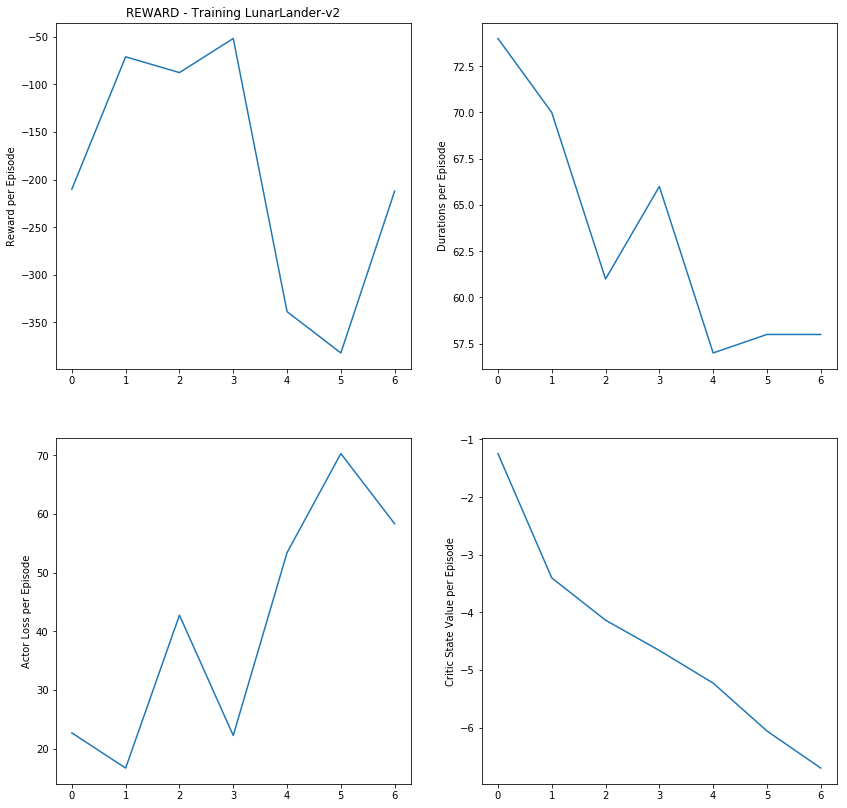

... in episode (7) step (80)


In [ ]:
start('LunarLander-v2')